# Generate Audio for Behavior Task

## Initial setup

In [1]:
import wave, struct, math
import numpy as np
from scipy import signal
import os, json
import matplotlib.pyplot as plt

In [2]:
output_dir = os.getcwd()
print(output_dir)

/home/ckemere/Code/TreadmillIO/ClientSide/Sounds


## Generate frequency modulated tone stimulus where pitch oscillates as sinewave when plotted on a log scale

Specifically, instantaneous $\phi(t) = f_c 2^{B/2 * \sin(2 \pi f_m t)}$, where $f_c$ is the fundamental pitch, $f_m$ is the modulation frequency, and $B$ is the bandwidth of the oscillations in octaves. $B=2$ implies the frequency shifts by 2 octaves from the carrier

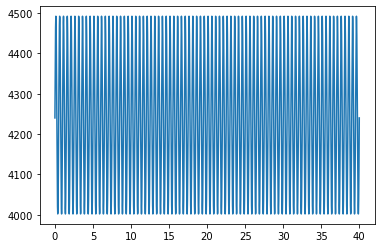

In [41]:
fs = 96000
T = 40
f_c = 4240
f_m = 2
t = np.arange(int(fs*T)+1)/fs
pi = np.pi
B = 0.1667 # (bandwidth)
mod = (2**(B/2 * np.sin(2*pi*f_m*t)))
mod[-1] = mod[0]
y = mod*f_c
plt.plot(t, y)

from scipy.interpolate import CubicSpline

cs = CubicSpline(t,y, extrapolate='periodic',bc_type='periodic')
# y2 = cs(t)
# plt.plot(t, y2)
cs2 = cs.antiderivative() # integrate to get time
# plt.plot(t, cs2(t))

sound = np.cos(2*pi*cs2(t))

In [30]:
mod[0], mod[-1]

(0.0, -7.837739514543061e-14)

In [42]:
s1 = sound[0]
print( (np.abs(s1 - sound[int(fs/f_m)::int(fs/f_m)])) / (1-sound[1])) # It's not periodic!
idx = np.argmin((np.abs(s1 - sound[int(fs/f_m)::int(fs/f_m)])) / (1-sound[1]))
print(idx, min((np.abs(s1 - sound[int(fs/f_m)::int(fs/f_m)])) / (1-sound[1])))

[2.29578111e+01 5.15016071e+01 3.54889364e+01 3.04901373e+00
 1.11685566e+01 4.55840878e+01 4.58383688e+01 1.14847083e+01
 2.87165698e+00 3.51296305e+01 5.15915396e+01 2.33390000e+01
 2.81645958e-03 2.25773061e+01 5.14062079e+01 3.58462318e+01
 3.23134943e+00 1.08556247e+01 4.53256101e+01 4.60884103e+01
 1.18040259e+01 2.69930976e+00 3.47683772e+01 5.16759887e+01
 2.37208023e+01 1.12655308e-02 2.21975585e+01 5.13053602e+01
 3.62014413e+01 3.41862477e+00 1.05459839e+01 4.50630043e+01
 4.63341368e+01 1.21264014e+01 2.53203550e+00 3.44053239e+01
 5.17549187e+01 2.41030359e+01 2.53408593e-02 2.18187746e+01
 5.11991251e+01 3.65543526e+01 3.61071866e+00 1.02398317e+01
 4.47964242e+01 4.65754264e+01 1.24516908e+01 2.36989351e+00
 3.40405831e+01 5.18283140e+01 2.44856349e+01 4.50373724e-02
 2.14409681e+01 5.10875028e+01 3.69049999e+01 3.80765843e+00
 9.93710281e+00 4.45258261e+01 4.68123149e+01 1.27799272e+01
 2.21286962e+00 3.36741407e+01 5.18961789e+01 2.48686114e+01
 7.03550786e-02 2.106412

In [20]:
s1, sound[idx*int(fs/f_m) + int(3*fs/f_m/2)]

(-0.4714570268938751, -0.47531100658626696)

In [43]:
A_max = 2**15-1 # max amplitude (short)
num_channels = 1 # 1 = mono, 2 = stereo


filename='caleb_lsFM_96k_4.24k_2_0.1667.wav'
# filename='caleb_lsFM_96k_8.485k_8_5.wav'
with wave.open(os.path.join(output_dir, filename),'wb') as wf:
    # File settings
    wf.setnchannels(num_channels)
    wf.setsampwidth(2) # 2 bytes = short
    wf.setframerate(fs)
    
    sound = (A_max*sound[:(idx+1)*int(fs/f_m)]).astype(np.int16)
#     sound = (A_max*sound[int(fs/f_m/2):idx*int(fs/f_m)+int(3*fs/f_m/2)]).astype(np.int16)
    
    # Write frames to file object
    for i in range(len(sound)):
        s = struct.pack('<h', sound[i]) # pack as short
        for j in range(num_channels):
            wf.writeframesraw(s)

### Generate audio

In [3]:
2**(0.1667)

1.1224879829891168

In [126]:
def log_sine(fs, T, 
               f_c=4000,
               f_m=2,
               bandwidth=1, # in octaves
               A = 1
            ):
    # Determine number of samples
    t = np.arange(int(fs*T))/fs
    
    pi = math.pi
    
#     y = np.sin(2*pi*t*f_c* (2**(bandwidth * np.sin(2*pi*f_m*t))))
    y = np.sin(2*pi*f_c*t + f_c* (2**(B * np.sin(2*pi*f_m*t))))


    # Normalize
    return y*(A/np.max(y))

In [127]:
filename = 'log_sine.wav'

# Audio settings
num_channels = 1 # 1 = mono, 2 = stereo
fs = 96000.0 # Hz
T = 1.0 # duration (s)
A_max = 2**15-1 # max amplitude (short)
A = 1.0*A_max # sample amplitude
f_c = 4000
f_m = 2
bandwidth = 1

with wave.open(os.path.join(output_dir, filename),'wb') as wf:
    # File settings
    wf.setnchannels(num_channels)
    wf.setsampwidth(2) # 2 bytes = short
    wf.setframerate(fs)
    
    # Create sound
    y = log_sine(fs=fs, 
                   T=T, 
                   A=A,
                   f_c = f_c,
                   f_m = f_m,
                   bandwidth=bandwidth)
    y = y.astype(np.int16)
    
    # Write frames to file object
    for i in range(len(y)):
        s = struct.pack('<h', y[i]) # pack as short
        for j in range(num_channels):
            wf.writeframesraw(s)

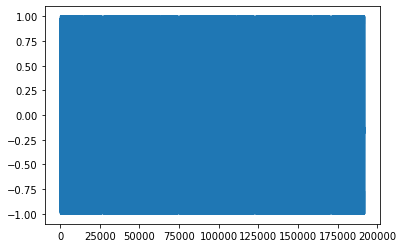

In [125]:
T = 2
f_c = 4000
t = np.arange(int(fs*T))/fs
pi = math.pi
B = (bandwidth)
mod = (2**(B * np.sin(2*pi*f_m*t)))
y = np.sin(2*pi*f_c*t + f_c* (2**(B * np.sin(2*pi*f_m*t))))
# plt.plot(t[:100], mod[:100] - mod[48000:48100])
plt.plot(y)

In [111]:
np.sin(t[96000:96000+N]*f_c*2*pi*mod[:N])

array([-2.57133317e-12,  5.64067277e-01])

In [110]:
np.sin(t[:N]*f_c*2*pi*mod[:N])

array([0.        , 0.25884199])

In [106]:
96000/16

6000.0

In [14]:
# Check file header
with wave.open(os.path.join(output_dir, filename), 'rb') as wf:
    T_actual = wf.getnframes() / wf.getframerate()
    print('Number of channels: %d' % wf.getnchannels())
    print('Duration:           %.2f' % T_actual)
    print('')

Number of channels: 1
Duration:           60.00



In [36]:
# Play audio
print('Playing file %s (%.2f seconds)' % (filename, T_actual))
os.system('aplay %s' % (os.path.join(output_dir, filename)))
print('done.')

Playing file tone_cloud.wav (60.00 seconds)
done.


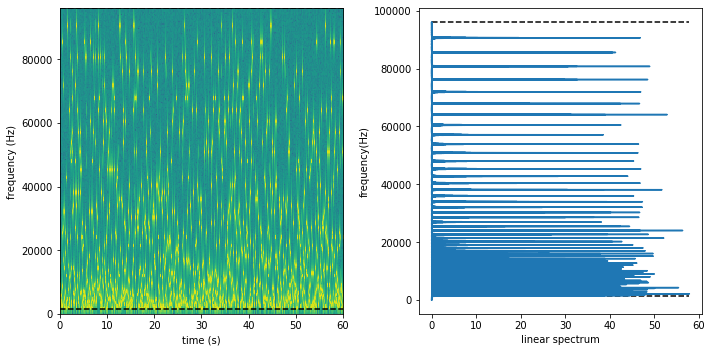

In [31]:
# Check characteristics of tone cloud
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot spectrogram
ax[0].specgram(y, Fs=int(fs), NFFT=512)
ax[0].hlines((f_low, f_high), (0.0,)*2, (T,)*2, 
             color='black', linestyle='--')
ax[0].set_xlim([0.0, T])
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('frequency (Hz)')

# Plot PSD vs. frequency
freq, Pxx = signal.periodogram(y, fs=fs, scaling='spectrum')
ax[1].plot(np.sqrt(Pxx[1:-1]), freq[1:-1])
ax[1].hlines((f_low, f_high), (0.0,)*2, (np.sqrt(Pxx[1:-1]).max(),)*2, 
             color='black', linestyle='--')
ax[1].set_xlabel('linear spectrum')
ax[1].set_ylabel('frequency(Hz)')

plt.tight_layout();

In [128]:
from scipy.io import wavfile

In [129]:
samplerate, data = wavfile.read('lsFM_96k_4.24k_2_0.1667_1s.wav')

In [130]:
data.shape

(96000,)

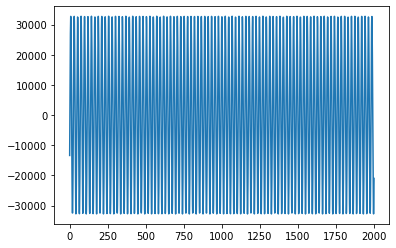

In [135]:
plt.plot(data[:2000])